In [1]:
import zipfile

import pandas as pd
import numpy as np

from IPython.display import Image, display  #To display images in a notebook
import matplotlib.pyplot as plt
import seaborn as sns

#Data preprocessing
from sklearn.experimental import enable_iterative_imputer   #Required to enable IterativeImputer
from sklearn.impute import IterativeImputer     #to HANDLE missing values
from sklearn.preprocessing import StandardScaler #To standardise variables
from sklearn.preprocessing import LabelEncoder #TO cencode categorical variables

#Splitting Training and test sets
from sklearn.multioutput import MultiOutputRegressor #for mulit output REgression
from sklearn.ensemble import RandomForestRegressor #RandomForest regression model
from xgboost import XGBRegressor    #XGBoost based regression model
from sklearn.feature_selection import SelectFromModel #TO select the most relevant features

#Model performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from datetime import datetime
import joblib   #To save and load training models
import os

In [2]:
!kaggle datasets download -d excel4soccer/espn-soccer-data


Dataset URL: https://www.kaggle.com/datasets/excel4soccer/espn-soccer-data
License(s): MIT
... resuming from 176163050 bytes (493820 bytes left) ...




100%|█████████▉| 168M/168M [00:00<?, ?B/s]
100%|█████████▉| 168M/168M [00:00<00:02, 165kB/s]


In [2]:
import zipfile

zip_path = "espn-soccer-data.zip"
extract_path = "espn_data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")


Extraction completed.


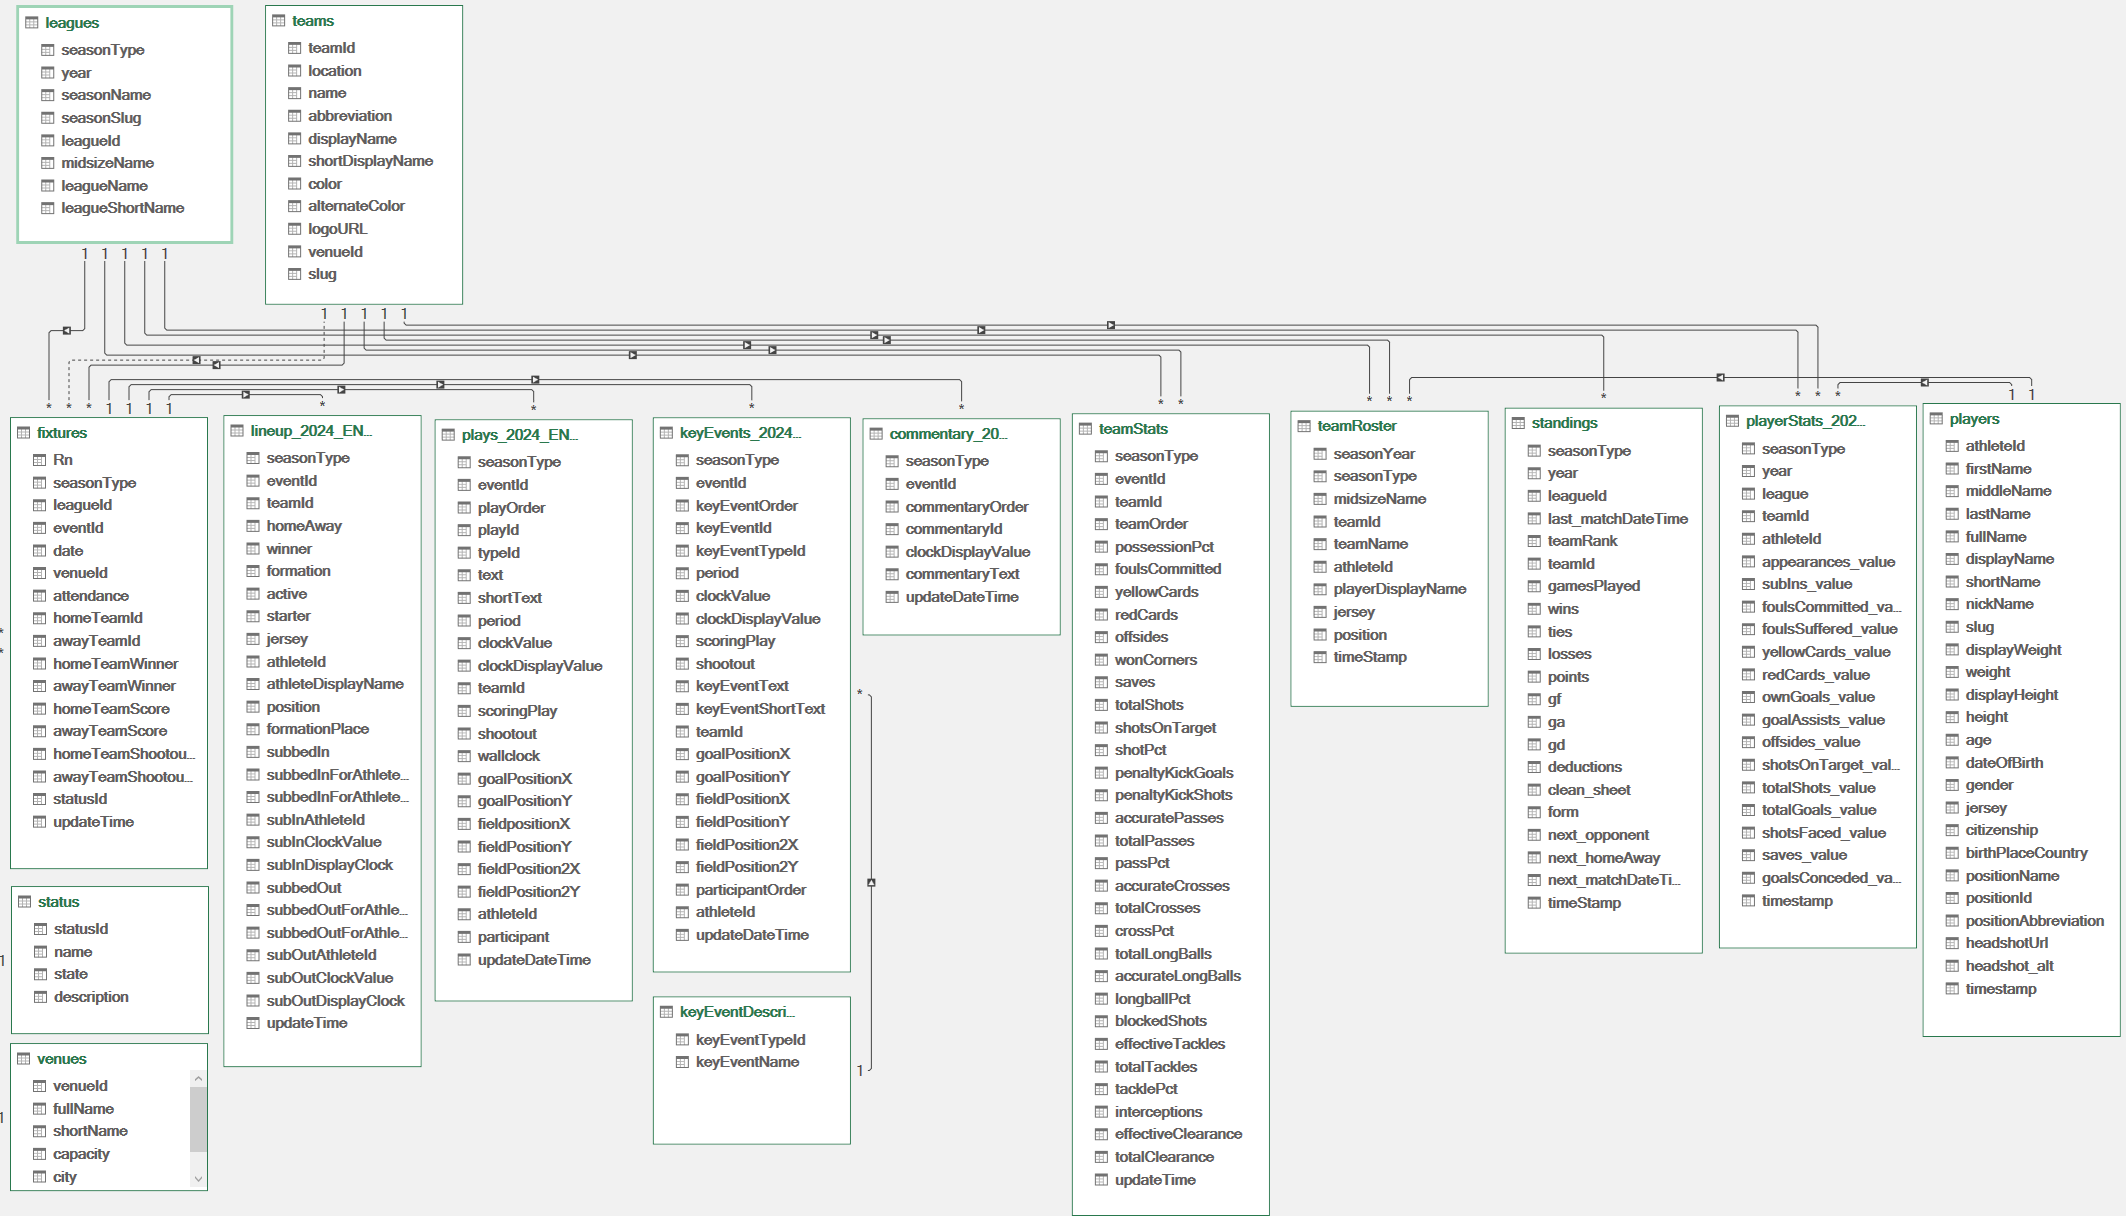

In [5]:
image_path="espn_data/base_data/dB_diagram.png"
display(Image(filename=image_path))

In [3]:
fixtures=pd.read_csv("espn_data/base_data/fixtures.csv")
print(" Preview of Fixtures ")
print(fixtures.head())

 Preview of Fixtures 
   Rn  seasonType  leagueId  eventId                 date  venueId  \
0   1       12136      3922   689519  2024-01-01 05:00:00     8680   
1   2       12136      3922   694555  2024-01-01 13:30:00     4775   
2   3       12136      3922   693431  2024-01-02 13:00:00     7614   
3   4       12136      3922   694586  2024-01-04 12:00:00     9877   
4   5       12136      3922   690701  2024-01-04 13:30:00     9876   

   attendance  homeTeamId  awayTeamId  homeTeamWinner  awayTeamWinner  \
0       61916         627        4396            True           False   
1           0         658        1928           False            True   
2           0        4895        2621           False            True   
3           0        1928        6723           False            True   
4           0         655        4388            True           False   

   homeTeamScore  awayTeamScore  homeTeamShootoutScore  awayTeamShootoutScore  \
0              5              0      

In [4]:
teamStats=pd.read_csv("espn_data/base_data/teamStats.csv")
print(teamStats.head())

   seasonType  eventId  teamId  teamOrder  possessionPct  foulsCommitted  \
0       12136   688265    4381          0           41.5             6.0   
1       12136   688265     628          1           58.5            19.0   
2       12136   689519     627          0           58.9             7.0   
3       12136   689519    4396          1           41.1             6.0   
4       12136   689956     448          0           52.9            11.0   

   yellowCards  redCards  offsides  wonCorners  ...  accurateLongBalls  \
0          1.0       0.0       1.0         1.0  ...               24.0   
1          1.0       0.0       3.0         3.0  ...               26.0   
2          0.0       0.0       1.0        13.0  ...               27.0   
3          2.0       0.0       1.0         3.0  ...               19.0   
4          1.0       0.0       2.0         7.0  ...               20.0   

   longballPct  blockedShots  effectiveTackles  totalTackles  tacklePct  \
0          0.4         

In [5]:
standings=pd.read_csv("espn_data/base_data/standings.csv")
print(standings.head())

   seasonType  year  leagueId   last_matchDateTime  teamRank  teamId  \
0       12215  2024     19915  2024-10-26 21:00:00         1   20684   
1       12215  2024     19915  2024-10-27 00:00:00         2   21354   
2       12215  2024     19915  2024-10-27 00:00:00         3   19995   
3       12215  2024     19915  2024-10-26 23:00:00         4   19964   
4       12215  2024     19915  2024-10-27 00:00:00         5   21821   

   gamesPlayed  wins  ties  losses  ...    gf    ga  gd  deductions  \
0           22    15     3       4  ...  47.0  24.0  23           0   
1           22    12     5       5  ...  34.0  18.0  16           0   
2           22    10     9       3  ...  35.0  18.0  17           0   
3           22    11     4       7  ...  39.0  28.0  11           0   
4           22     9     8       5  ...  23.0  16.0   7           0   

   clean_sheet   form next_opponent  next_homeAway next_matchDateTime  \
0          7.0  WDWWW           NaN            NaN                N

In [6]:
leagues=pd.read_csv("espn_data/base_data/leagues.csv")
print(leagues.head())

   seasonType  year                                         seasonName  \
0       12868  2024   2024-25 AFC Champions League Elite, League Stage   
1       12864  2024          2024-25 AFC Champions League Elite, Final   
2       12865  2024     2024-25 AFC Champions League Elite, Semifinals   
3       12866  2024  2024-25 AFC Champions League Elite, Quarterfinals   
4       12867  2024    2024-25 AFC Champions League Elite, Round of 16   

      seasonSlug  leagueId    midsizeName                  leagueName  \
0   league-stage      3902  AFC.CHAMPIONS  AFC Champions League Elite   
1          final      3902  AFC.CHAMPIONS  AFC Champions League Elite   
2     semifinals      3902  AFC.CHAMPIONS  AFC Champions League Elite   
3  quarterfinals      3902  AFC.CHAMPIONS  AFC Champions League Elite   
4    round-of-16      3902  AFC.CHAMPIONS  AFC Champions League Elite   

              leagueShortName  
0  AFC Champions League Elite  
1  AFC Champions League Elite  
2  AFC Champions Lea

In [7]:
#EXPLORATORY ANALYSIS

def explore_distributions(df, df_name):
    #Select numeric columns
    numeric_cols=df.select_dtypes(include=['number']).columns.tolist() #Extracts all column names in the DataFrame that contain numeric data types (integers or floats) and stores them in a list.  
    if not numeric_cols:        #Checks if the list of numeric columns is empty. If there are no numeric columns, it skips the analysis. 
        print(f"No numeric collumns in {df_name}")
        return
    
    print(f"\n=== Descriptive Statistics for {df_name}")
    print(df[numeric_cols].describe())      #Provides summary stats

    #Iterate over each Numeric collum to display plots
    for col in numeric_cols:
        fig,axs= plt.subplots(1,2,figsize=(14,4)) #subplots allow plotting of multiple charts in one | 
        #plt.subplots and plt.subplot is diff | plt.subplot plots one-by-one and subplots does it all at once

        #Histogram with density estimation
        sns.histplot(df[col].dropna(),kde=True, ax=axs[0],color='skyblue') #dropna stands for drop Not a Number and it removes any missing or empty values
        axs[0].set_title(f"Histogram of {col} ({df_name})")
        axs[0].set_xlabel(col)
        axs[0].set_ylabel("Frequency")

        #Box Plot
        sns.boxplot(x=df[col].dropna(),ax=axs[1],color='lightgreen')
        axs[1].set_title(f"Boxplot of {col} ({df_name})")
        axs[1].set_xlabel(col)

        plt.tight_layout    #Adjusts subplot layout so that plots don't overlap or appear too tight.
        plt.show()
        



### Distribution Analysis for fixtures ###

=== Descriptive Statistics for fixtures
                 Rn    seasonType      leagueId        eventId       venueId  \
count  67262.000000  67262.000000  67262.000000   67262.000000  67262.000000   
mean     240.894487  13017.852190   6054.179537  727184.492670   4795.690880   
std      468.536179    440.824406   5682.950421   20098.889187   3139.315486   
min        1.000000  12136.000000    601.000000  688265.000000     -1.000000   
25%       39.000000  12673.000000   3903.000000  710223.250000   1963.000000   
50%      109.000000  13041.000000   3943.000000  727394.500000   5375.000000   
75%      229.000000  13446.000000   8207.000000  744555.750000   7054.000000   
max     3477.000000  13876.000000  23633.000000  762473.000000  10902.000000   

          attendance     homeTeamId     awayTeamId  homeTeamScore  \
count   67262.000000   67262.000000   67262.000000   67262.000000   
mean     6479.494856   11303.496536   11499.493399     

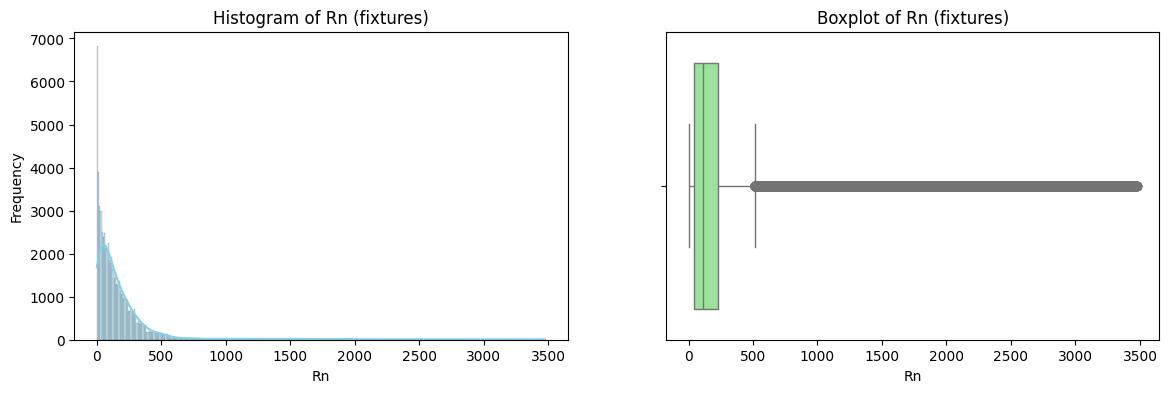

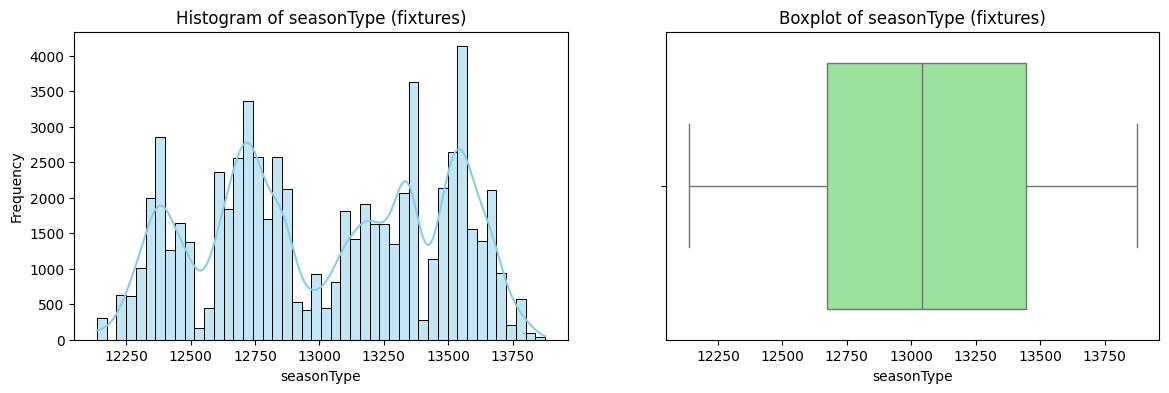

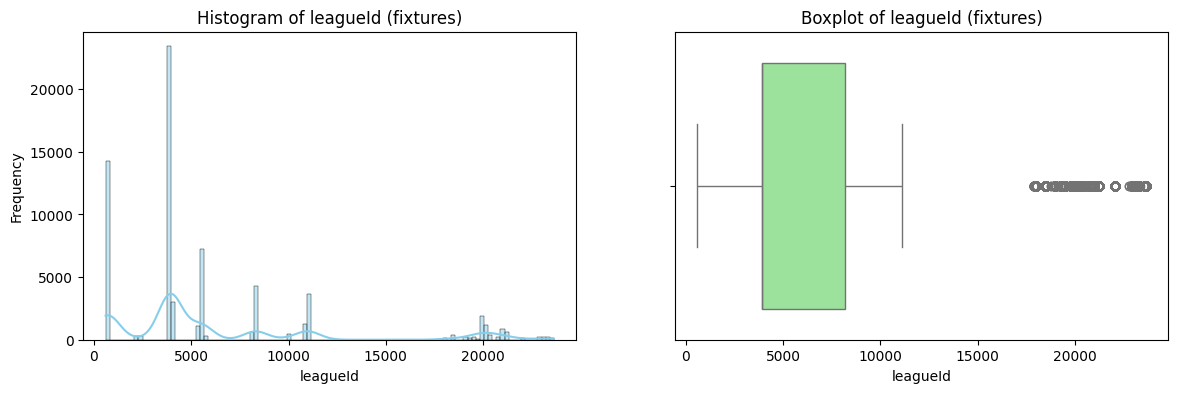

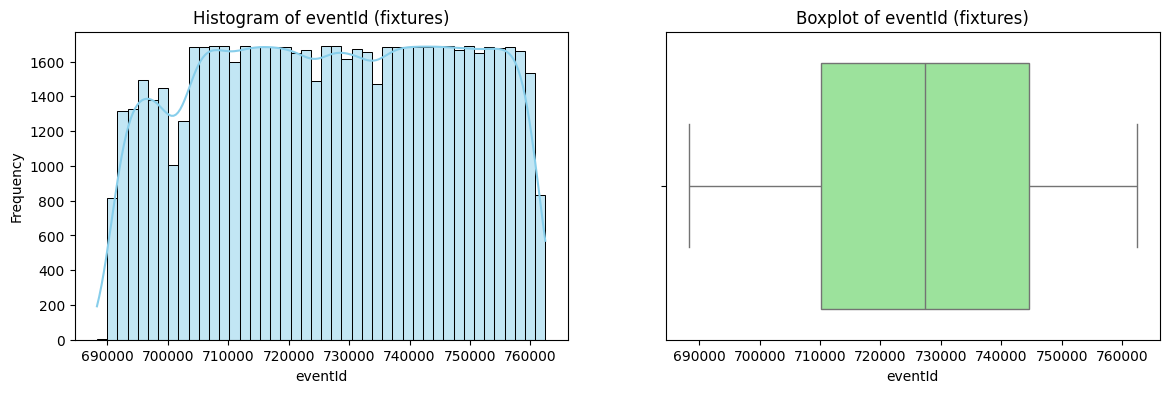

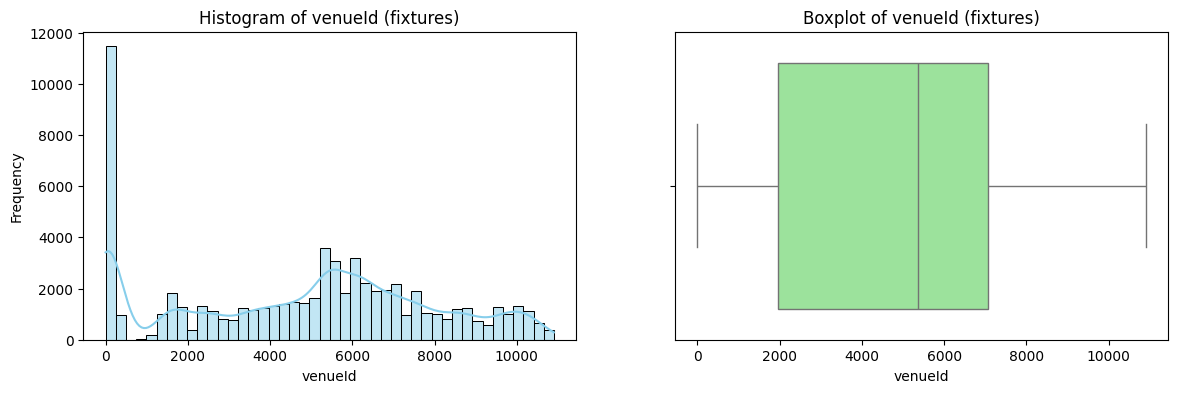

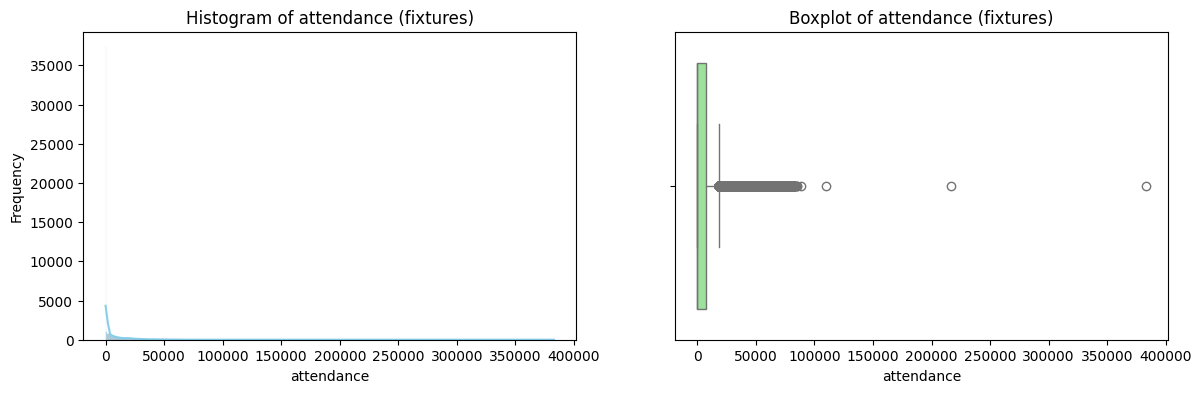

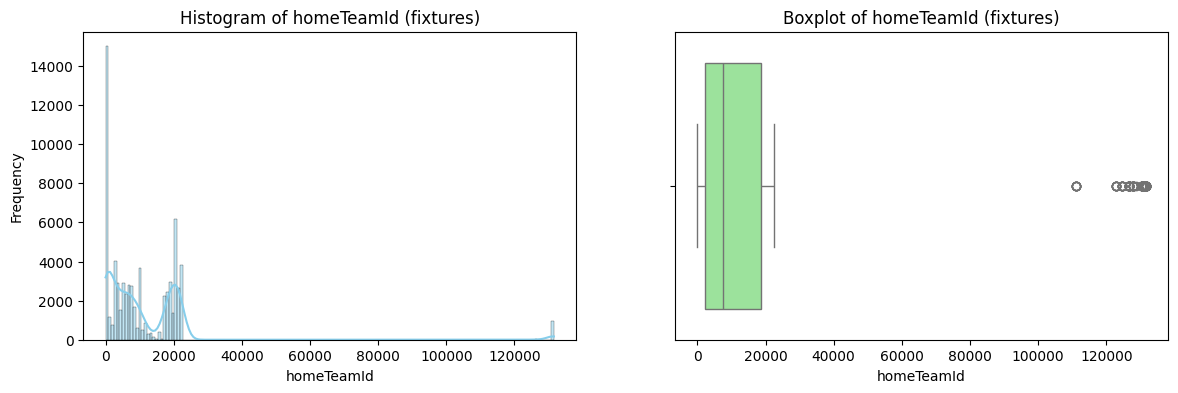

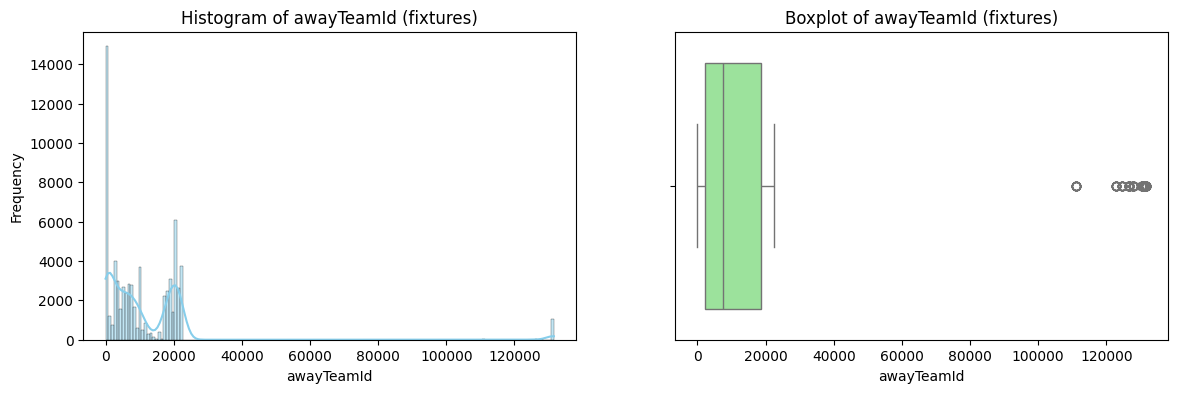

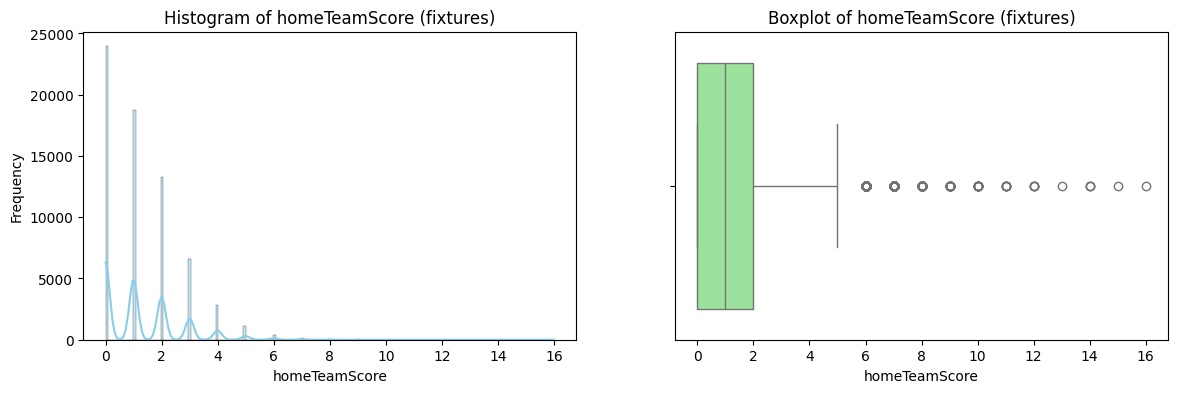

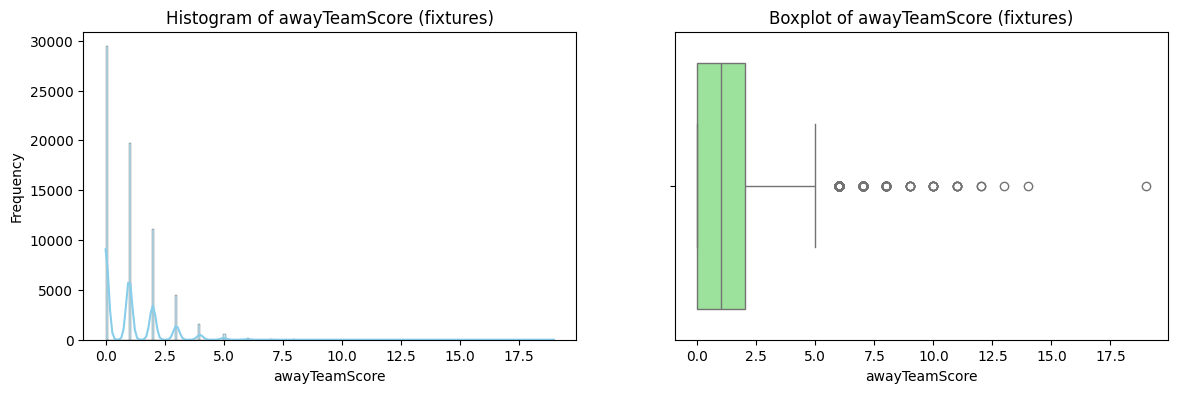

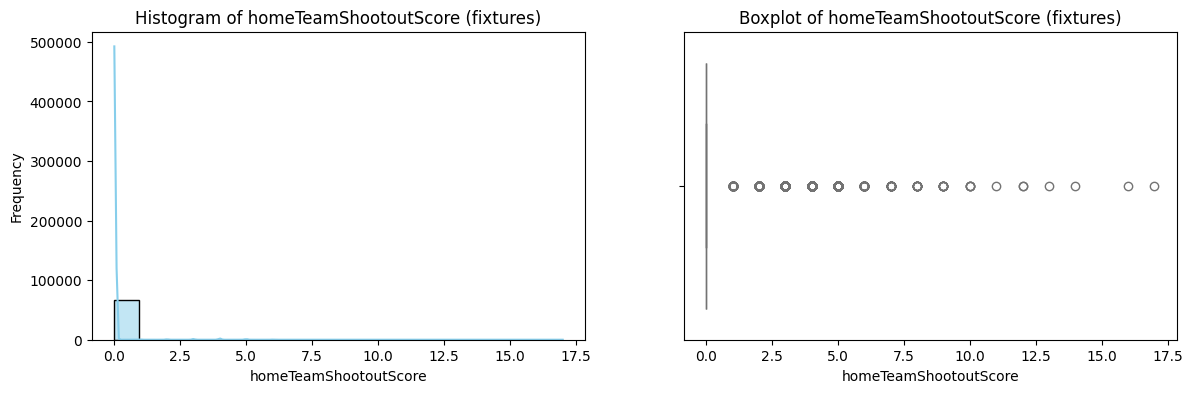

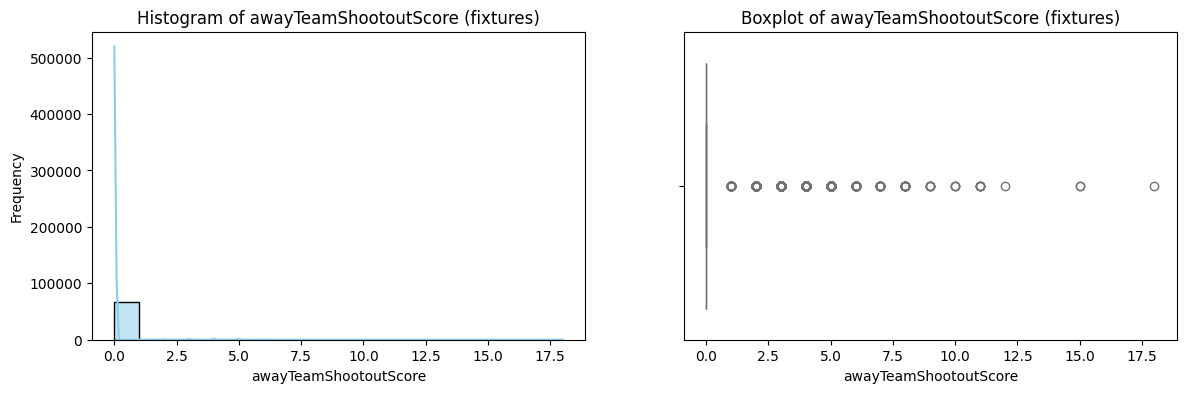

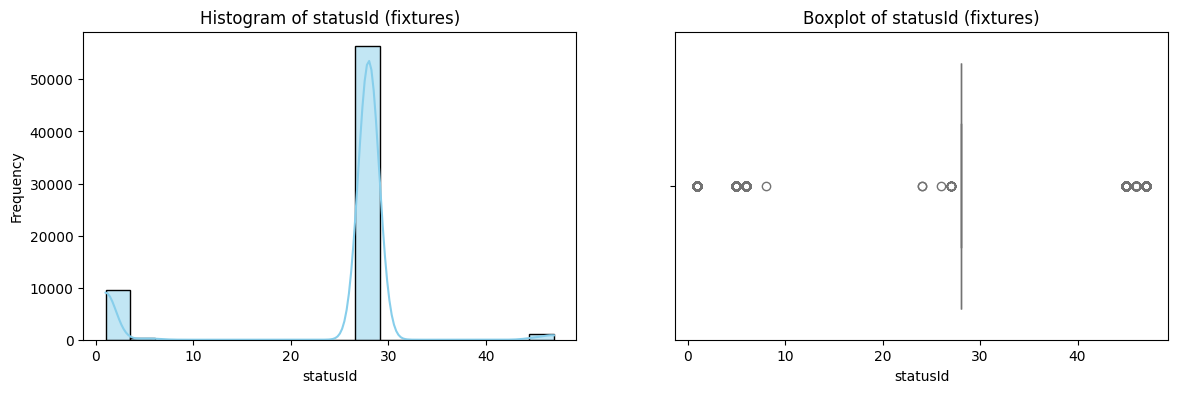

In [8]:
name="fixtures"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(fixtures, name)

In [ ]:
name="teamStats"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(teamStats, name)

In [ ]:
name="standings"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(standings, name)

In [ ]:
name="leagues"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(leagues, name)